# Outline

In this project, I have developed ResNet-50 network to do transfer leraning on the Freits 360 dataset. 

**Architecture**

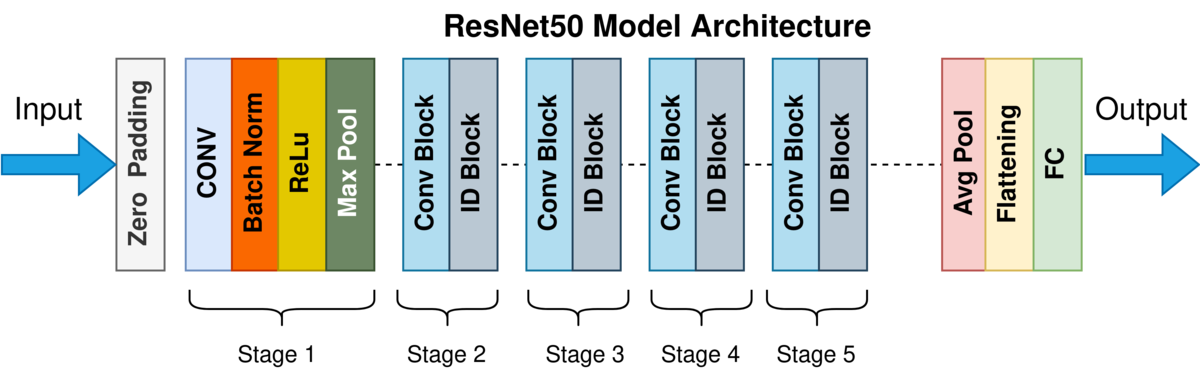

The ResNet architecture is considered to be among the most popular Convolutional Neural Network architectures around. Introduced by Microsoft Research in 2015, Residual Networks (ResNet in short).

**Transfer learning** : 

In it, we take pre-train CNN, trained on large dataset, such as ImageNet, so that it's already found some good features.
So in this project, we will use VGG model pretrained on ImageNet but we will exclude the final layer or the head.

**Transfer learning in 6 steps**

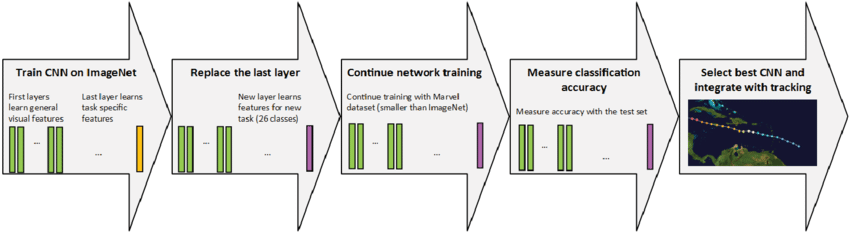

1.   Obtain the pre-trained model: The first step is to get the pre-trained model that we would like to use for our problem.

2.   Create a base model: Next step is to instantiate the base model using one of the architectures such as VGG, ResNet or Xception.

1.   Freeze layers so they don't change during training : base_model.trainable = False 

*   Freezing the layers from the pre-trained model is vital. This is because you don't want the weights in those layers to be re-initialized. If they are, then we will lose all the learning that has already taken place. This will be no different from training the model from scratch.

4.   Add new trainable layers : The next step is to add new trainable layers that will turn old features into predictions on the new dataset. This is important because the pre-trained model is loaded without the final output layer. 

5.   Train the new layers on the dataset: As we know, that the pre-trained model's final output will most likely be different from the output that we want for our model

6.   Improve the model via fine-tuning: Once we have done the previous step, we will have a model that can make predictions on our custom dataset. Optionally, we can improve its performance through fine-tuning.


**About Dataset**

Fruits 360 dataset: A dataset of images containing fruits and vegetables.
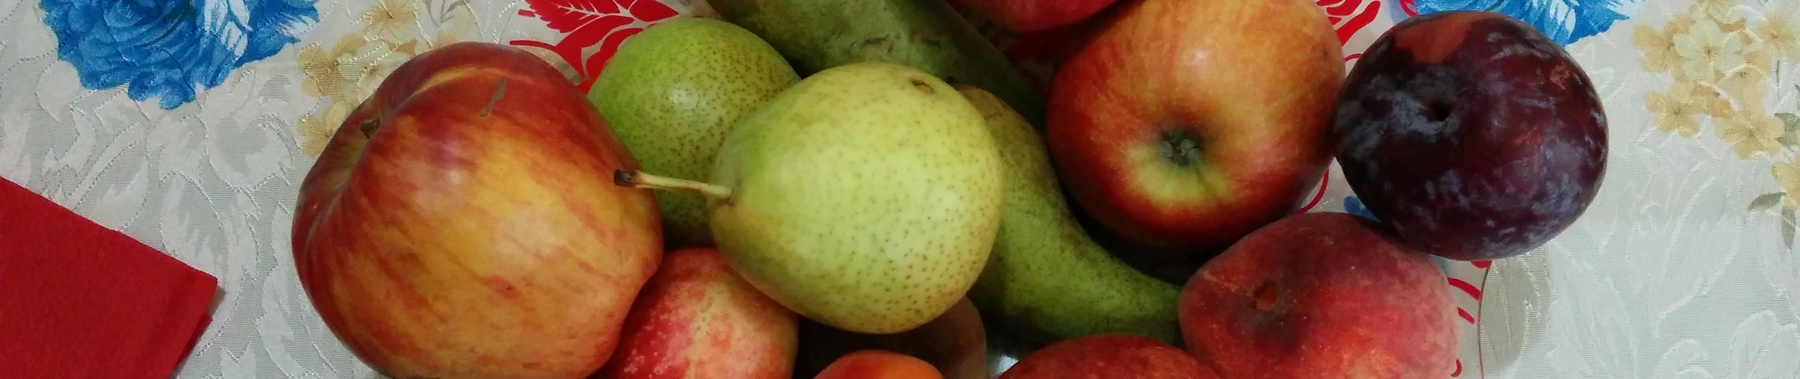

Dataset properties:

The total number of images: 90483.

Training set size: 67692 images (one fruit or vegetable per image).

Test set size: 22688 images (one fruit or vegetable per image).

The number of classes: 131 (fruits and vegetables).

Image size: 100x100 pixels.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] 

# training config:
epochs = 16
batch_size = 128

In [ ]:
# Downloading data 
# https://www.kaggle.com/moltean/fruits
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2023-05-30 21:29:43--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  21.7MB/s    in 8.5s    

2023-05-30 21:29:52 (21.5 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [ ]:
# Unzip data
!unzip -nq fruits-360.zip

In [ ]:
# Setting train_path and valid_path
# Here I'm using full dataset/ rather than small version as done in VGG architecture 
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [ ]:
# Getting a list of every image file in the train and valid path, as it is useful for getting no. of traning and valid samples 
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [ ]:
# Getting a list of folders in the train path, useful for getting number of classes
folders = glob(train_path + '/*')

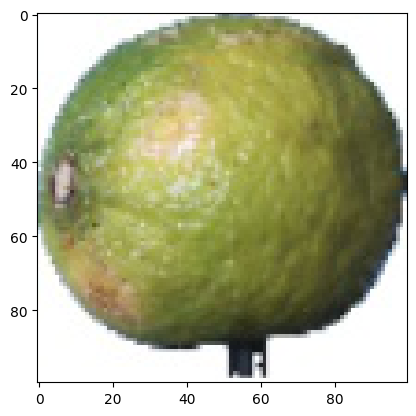

In [ ]:
# Plotting an random image, for sanity check
plt.imshow(image.load_img(np.random.choice(image_files)));

In [ ]:
# Instantiate ResNet50 with pre-trained ImageNet weights and since I'm doing transfer learning, so include_top is set to False 
res = ResNet50(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Setting trainable attribute for each ResNet layer to False, as this will frezze the ResNet layer. So that when we train our model only the final layer will be trained 
for layer in res.layers:
  layer.trainable = False

In [ ]:
# Defining own layers - which will operate on the o/p of the ResNet body
# Here, 1st step is to flatten the o/p, since ResNet is the series of convolutions, which will give us an image.
# Next step, is to define Dense layers- which is experimental, here I have added one  

x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# Defining a model object using the ResNet input as the I/O and O/P of our final Dense layer as the O/P.
model = Model(inputs=res.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# Calling model. compile - and telling model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Data augmentation
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [ ]:
# Testing generator to see how it works 
# and get label mapping for confusion matrix plot later

test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

min: -79.68 max: 151.061


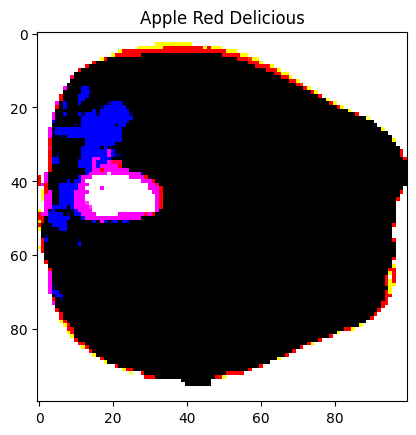

In [ ]:
# plotting images produced by the generator, this should be a strangely colored image (due to pre-process input function sepecific to ResNet)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
# create data generators from the generator object instantiated earlier.

train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [ ]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/16
224/224 [==============================] - 125s 499ms/step - loss: 0.5904 - accuracy: 0.9196 - val_loss: 0.2307 - val_accuracy: 0.9577
Epoch 2/16
224/224 [==============================] - 106s 472ms/step - loss: 0.1338 - accuracy: 0.9769 - val_loss: 0.1164 - val_accuracy: 0.9762
Epoch 3/16
224/224 [==============================] - 112s 499ms/step - loss: 0.1323 - accuracy: 0.9822 - val_loss: 0.1215 - val_accuracy: 0.9800
Epoch 4/16
224/224 [==============================] - 120s 533ms/step - loss: 0.1283 - accuracy: 0.9842 - val_loss: 0.1739 - val_accuracy: 0.9832
Epoch 5/16
224/224 [==============================] - 110s 490ms/step - loss: 0.0893 - accuracy: 0.9893 - val_loss: 0.0879 - val_accuracy: 0.9852
Epoch 6/16
224/224 [==============================] - 114s 506ms/step - loss: 0.0810 - accuracy: 0.9911 - val_loss: 0.3937 - val_accuracy: 0.9697
Epoch 7/16
224/224 [==============================] - 114s 511ms/step - loss: 0.1181 - accuracy: 0.9886 - val_loss: 0.0393 -

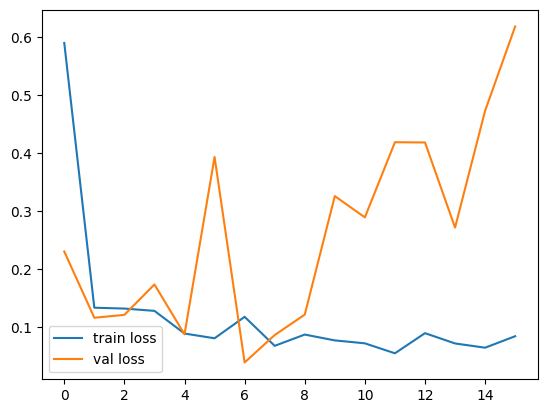

In [ ]:
# Plotting loss/epoch 
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

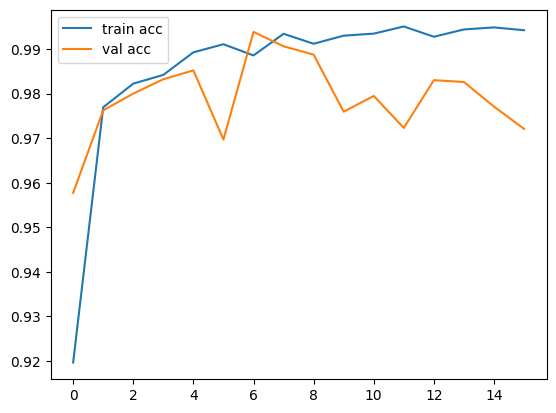

In [ ]:
# Plotting accuracies/epoch 

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

As we can see this model works much better than VGG. 

In [ ]:
# Function for obtaining the confusion matrix
# Here, I'm looping through generators first to obatain the predictions and targets as Numpy arrays.

def get_confusion_matrix(data_path, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
# Get confusion_matrix for the training set 
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 28736
Found 28736 images belonging to 60 classes.
8/8 [==============================] - 0s 26ms/step
12800 images processed.
8/8 [==============================] - 0s 36ms/step
25600 images processed.
2/2 [==============================] - 0s 23ms/step
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 484 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 490]]


As expected we can see, the largest number on the diagonal and zeros elsewhere.

In [ ]:
# Get confusion_matrix for the validation set 

valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 9673
Found 9673 images belonging to 60 classes.
7/7 [==============================] - 1s 97ms/step
[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 124 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 166]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(15, 15))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 484 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 490]]


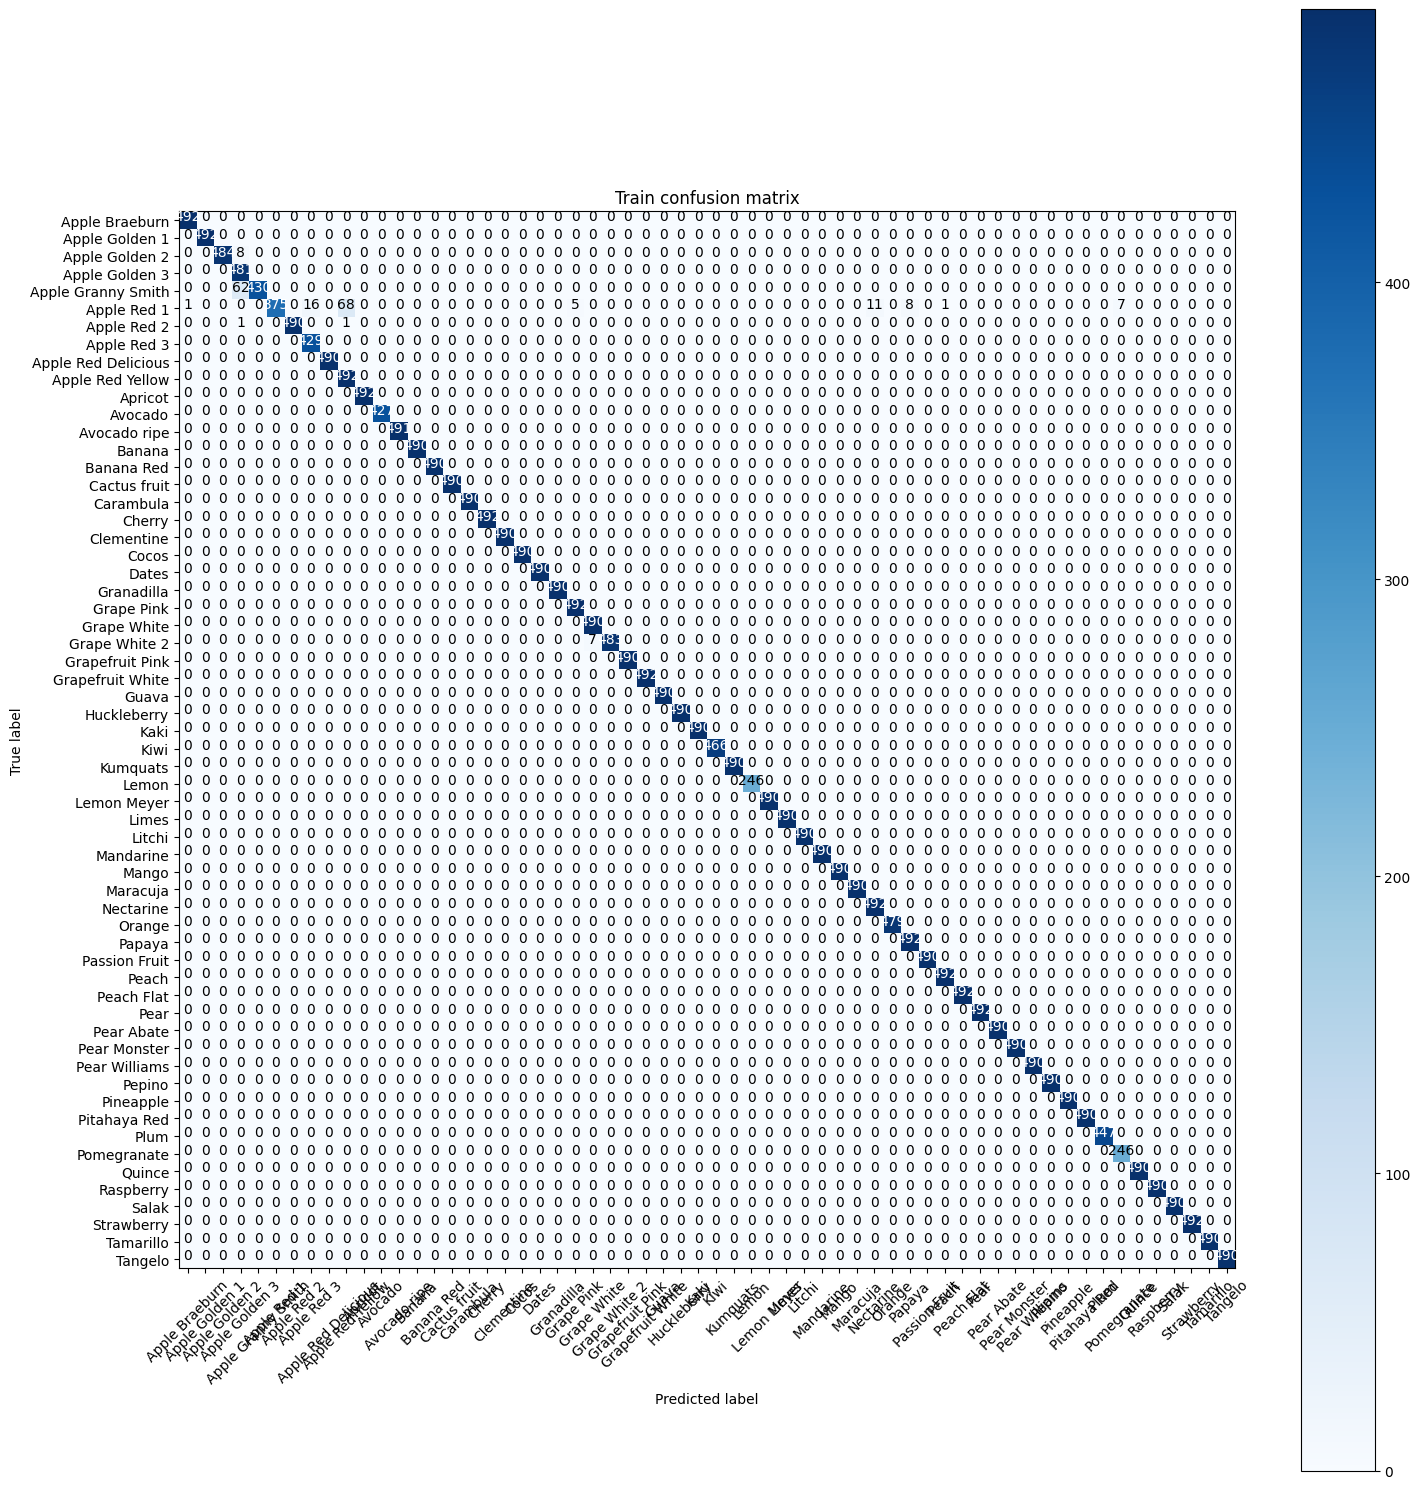

In [ ]:
# Plotting confusion_matrix for the training set 
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 124 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 166]]


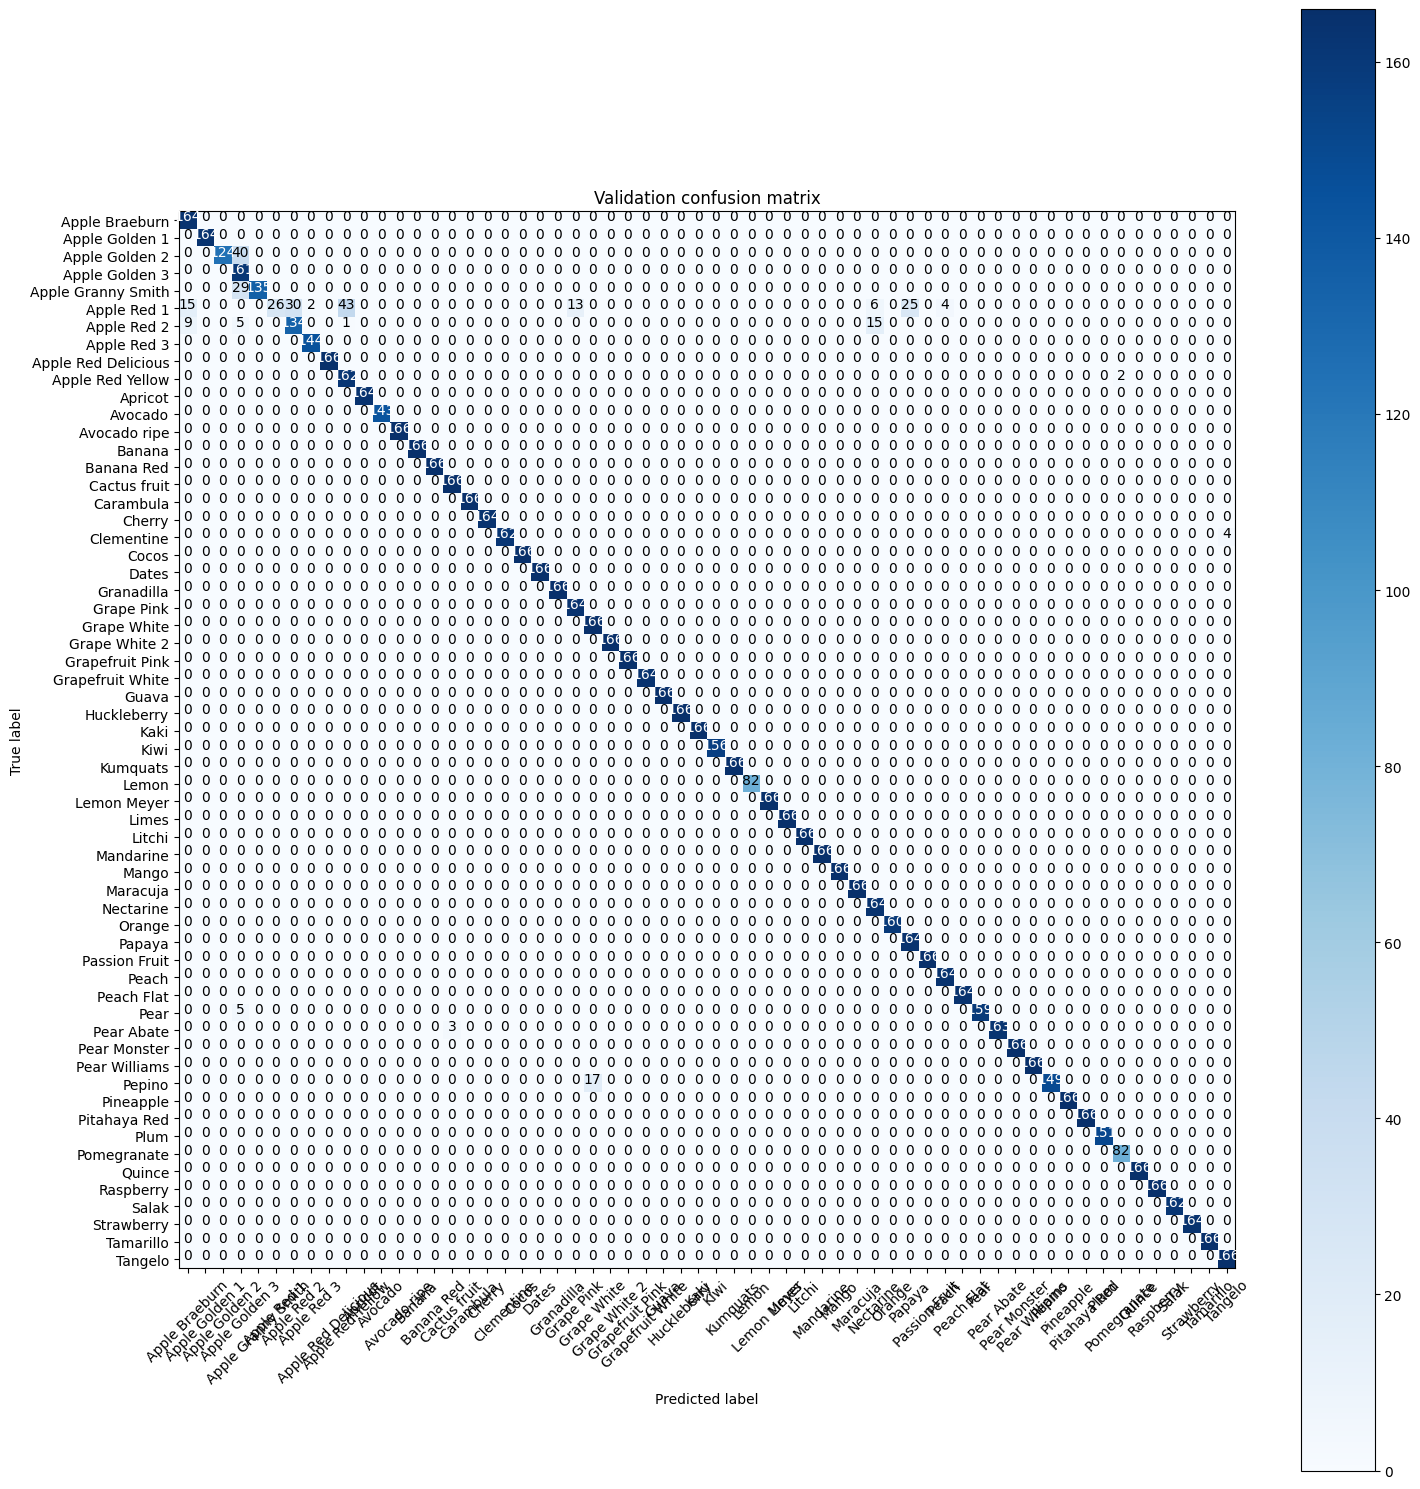

In [ ]:
# # Plotting confusion_matrix for the validation set 

plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')


We can see for most classes, we have made correct predictions for every sample.